In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
#%matplotlib notebook
import seaborn as sns
import pickle
from gryffin import Gryffin
from chimera import Chimera

from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors

sns.set(style='ticks', context='notebook', font_scale=1.2)

tolerances = [0.9, 0.]
chimera = Chimera(tolerances=tolerances, absolutes=[True, True], goals=['max', 'min'])


In [2]:
with open('random/results.pkl', 'rb') as content:
    data_random = pickle.load(content)
    
with open('deap/results.pkl', 'rb') as content:
    data_deap = pickle.load(content)
    
with open('opt_adam/results.pkl', 'rb') as content:
    data_adam = pickle.load(content)
    
with open('opt_genetic/results.pkl', 'rb') as content:
    data_gene = pickle.load(content)
    
with open('gpyopt/results.pkl', 'rb') as content:
    data_gpyopt = pickle.load(content)
    
print('N random:', len(data_random))
print('N deap:', len(data_deap))
print('N Gryffin (Adam, prior):', len(data_adam))
print('N Gryffin (Gene, prior):', len(data_gene))
print('N GPyOpt :', len(data_gpyopt))

N random: 100
N deap: 100
N Gryffin (Adam, prior): 100
N Gryffin (Gene, prior): 100
N GPyOpt : 100


In [49]:

def plot_trace_mean_verbose(
        data, obj_num=0, ax=None, color=None, linestyle='-', unc=True, alpha_line=1., alpha_unc=0.2,
        label=None, use_std_err=True, outline=True, convert_mu_g_min=False):

        
    traces = get_traces_verbose(data)[:, obj_num, :]
    
    if obj_num in [0, 1] and convert_mu_g_min:
        # convert from units of \mu L / min --> \mu g / min
        if obj_num == 0: 
            # C60 concentration = 2 mg/mL = 2 \mu g/ \mu L
            conc = 2.0
        elif obj_num == 1:
            # sultine concentration = 1.4 mg/mL = 1.4 \mu g/ \mu L
            conc = 1.4
            
        traces = traces * conc 
        
    if ax is None:
        fig, ax = plt.subplots()
    
    mean = np.mean(traces, axis=0)
    if use_std_err is True:
        stde = np.std(traces, axis=0, ddof=1) / np.sqrt(np.shape(traces)[0] - 1)
    else:
        stde = np.nanstd(traces, axis=0, ddof=1)

    x = np.arange(1, len(mean) + 1, 1)
        
    if outline is True:
        ax.plot(x, mean, color='#444444', linewidth=5, alpha=alpha_line)
    ax.plot(x, mean, color=color, linestyle=linestyle, linewidth=4, label=label, alpha=alpha_line)
    
    if unc is True:
        ax.fill_between(x, y1=mean-1.96*stde, y2=mean+1.96*stde, alpha=alpha_unc, color=color)
        ax.plot(x, mean-1.96*stde, color=color, linewidth=1, alpha=0.5)
        ax.plot(x, mean+1.96*stde, color=color, linewidth=1, alpha=0.5)
        
    if convert_mu_g_min:
        mean_last = np.mean(traces[:, -1])
        ax.axhline(mean_last, ls='--', lw=2, c=color, alpha=0.8 )
        
        return mean_last
    else:
        return None
        
def plot_trace_mean(data, obj_num=0, ax=None, color=None, linestyle='-', unc=True, alpha_line=1., alpha_unc=0.2,
                    label=None, use_std_err=True, outline=True):
        
    traces = get_traces(data)[:, obj_num, :]
    
    if ax is None:
        fig, ax = plt.subplots()
    
    mean = np.mean(traces, axis=0)
    if use_std_err is True:
        stde = np.std(traces, axis=0, ddof=1) / np.sqrt(np.shape(traces)[0] - 1)
    else:
        stde = np.nanstd(traces, axis=0, ddof=1)

    x = np.arange(1, len(mean) + 1, 1)
        
    if outline is True:
        ax.plot(x, mean, color='#444444', linewidth=5, alpha=alpha_line)
    ax.plot(x, mean, color=color, linestyle=linestyle, linewidth=4, label=label, alpha=alpha_line)
    
    if unc is True:
        ax.fill_between(x, y1=mean-1.96*stde, y2=mean+1.96*stde, alpha=alpha_unc, color=color)
        ax.plot(x, mean-1.96*stde, color=color, linewidth=1, alpha=0.5)
        ax.plot(x, mean+1.96*stde, color=color, linewidth=1, alpha=0.5)


def plot_trace_sigle(pkl_file, ax, obj_name, goal='min', color='k', label='', shift=0.0, use_std_err=True):
    with open(pkl_file, 'rb') as content:
        data = pickle.load(content)
    plot_trace_mean(data, obj_name, goal=goal, ax=ax, color=color, label=label, shift=shift, use_std_err=use_std_err)
    

def gradient_patch(ax, xmin, xmax, ymin, ymax, fill_color='k', alpha=1, zorder=1):
    
    x = np.linspace(xmin, xmax, 100)
    y = np.linspace(ymin, ymax, 100)
    
    z = np.empty((100, 1, 4), dtype=float)
    rgb = mcolors.colorConverter.to_rgb(fill_color)
    z[:,:,:3] = rgb
    z[:,:,-1] = np.linspace(0, alpha, 100)[:,None]

    im = ax.imshow(z, aspect='auto', extent=[xmin, xmax, ymin, ymax],
                   origin='lower', zorder=zorder)

    xy = np.column_stack([x, y])
    xy = np.vstack([[xmin, ymin], xy, [xmax, ymin], [xmin, ymin]])
    clip_path = Rectangle(xy=(xmin, ymin), width=xmax-xmin, height=ymax-ymin, 
                          facecolor='none', edgecolor='none')
    ax.add_patch(clip_path)
    im.set_clip_path(clip_path)

In [16]:
def get_traces(data):
    traces = []
    for df in data:
        scalarized = chimera.scalarize(df.loc[:, ['obj0', 'obj1']])

        trace_best_idx = [np.argmin(scalarized[:i+1]) for i in range(len(scalarized))]
        trace0 = [df.loc[i, 'obj0'] for i in trace_best_idx]
        trace1 = [df.loc[i, 'obj1'] for i in trace_best_idx]
        trace2 = [df.loc[i, 'MA'] for i in trace_best_idx]
        trace3 = [df.loc[i, 'BA'] for i in trace_best_idx]
        
        traces.append([trace0, trace1, trace2, trace3])
    return np.array(traces)

def get_traces_verbose(data):
    traces = []
    for df in data:
        scalarized = chimera.scalarize(df.loc[:, ['obj0', 'obj1']])

        trace_best_idx = [np.argmin(scalarized[:i+1]) for i in range(len(scalarized))]
        trace0 = [df.loc[i, 'obj0'] for i in trace_best_idx]
        trace1 = [df.loc[i, 'obj1'] for i in trace_best_idx]
        trace2 = [df.loc[i, 'MA'] for i in trace_best_idx]
        trace3 = [df.loc[i, 'BA'] for i in trace_best_idx]
        c60 = [df.loc[i, 'c60_flow'] for i in trace_best_idx]
        sultine = [df.loc[i, 'sultine_flow'] for i in trace_best_idx]
        T = [df.loc[i, 'T'] for i in trace_best_idx]
        
        traces.append([c60, sultine, T, trace0, trace1, trace2, trace3])
    return np.array(traces)

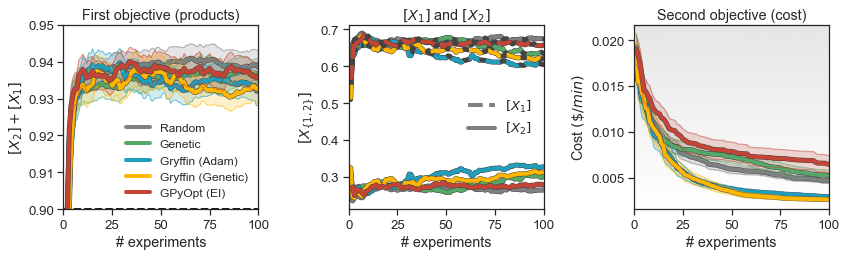

In [5]:
# MAKE SI PLOT --> all traces including GPyOpt
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 3.8), sharex=True, sharey=False)

plot_trace_mean(data_random, obj_num=0, ax=axes[0], color='gray', label='Random')
plot_trace_mean(data_random, obj_num=2, ax=axes[1], color='gray', linestyle='--', unc=False, label='$[X_1]$')
plot_trace_mean(data_random, obj_num=3, ax=axes[1], color='gray', linestyle='-', unc=False, label='$[X_2]$')
plot_trace_mean(data_random, obj_num=1, ax=axes[2], color='gray', label='Random')

plot_trace_mean(data_deap, obj_num=0, ax=axes[0], color='g', label='Genetic')
plot_trace_mean(data_deap, obj_num=2, ax=axes[1], color='g', linestyle='--', unc=False)
plot_trace_mean(data_deap, obj_num=3, ax=axes[1], color='g', linestyle='-', unc=False)
plot_trace_mean(data_deap, obj_num=1, ax=axes[2], color='g', label='Genetic')

# Gryffin (Adam) #f07167
plot_trace_mean(data_adam, obj_num=0, ax=axes[0], color='#219ebc', label='Gryffin (Adam)')
plot_trace_mean(data_adam, obj_num=2, ax=axes[1], color='#219ebc', linestyle='--', unc=False)
plot_trace_mean(data_adam, obj_num=3, ax=axes[1], color='#219ebc', linestyle='-', unc=False)
plot_trace_mean(data_adam, obj_num=1, ax=axes[2], color='#219ebc', label='Gryffin (Adam)')

# Gryffin (Genetic) #fc9636
plot_trace_mean(data_gene, obj_num=0, ax=axes[0], color='#ffb703', label='Gryffin (Genetic)')
plot_trace_mean(data_gene, obj_num=2, ax=axes[1], color='#ffb703', linestyle='--', unc=False)
plot_trace_mean(data_gene, obj_num=3, ax=axes[1], color='#ffb703', linestyle='-', unc=False)
plot_trace_mean(data_gene, obj_num=1, ax=axes[2], color='#ffb703', label='Gryffin (Genetic)')

# GPyOpt #c44536
plot_trace_mean(data_gpyopt, obj_num=0, ax=axes[0], color='#c44536', label='GPyOpt (EI)')
plot_trace_mean(data_gpyopt, obj_num=2, ax=axes[1], color='#c44536', linestyle='--', unc=False)
plot_trace_mean(data_gpyopt, obj_num=3, ax=axes[1], color='#c44536', linestyle='-', unc=False)
plot_trace_mean(data_gpyopt, obj_num=1, ax=axes[2], color='#c44536', label='GPyOpt (EI)')


axes[0].fill_between(x=[0,100], y1=0., y2=tolerances[0], alpha=0.3, color='gray')
axes[0].axhline(y=tolerances[0], linestyle='--', color='k', linewidth=2, zorder=0)

gradient_patch(ax=axes[2], xmin=0, xmax=100, ymin=axes[2].get_ylim()[0], ymax=axes[2].get_ylim()[1], 
               fill_color='gray', alpha=0.2)


axes[0].set_ylim([0.8, 0.96])
# axes[1].set_ylim([0.25, 0.60])
# axes[2].set_ylim([0.075, 0.225])

#axes[0].set_ylim([0.75, 2.75 ])
axes[0].set_xlim([0,100])
axes[0].set_ylim([0.90, 0.95])

axes[0].legend(frameon=False, ncol=1, fontsize=12, loc='lower right')
axes[1].legend(frameon=False)
#axes[2].legend(frameon=False)

axes[0].set_xlabel('# experiments')
axes[1].set_xlabel('# experiments')
axes[2].set_xlabel('# experiments')

axes[0].set_ylabel('$[X_2] + [X_1]$')
axes[1].set_ylabel('$[X_{\{1,2\}}]$')
axes[2].set_ylabel('Cost $(\$/min) $')

axes[0].set_title("First objective (products)")
axes[1].set_title("$[X_1]$ and $[X_2]$")
axes[2].set_title("Second objective (cost)")

plt.tight_layout()
#fig.savefig('fullerenes-results-products-shrunk.pdf', bbox_inches='tight')
#fig.savefig('fullerenes-results-products-shrunk.png', dpi=600, bbox_inches='tight')

In [12]:
# PLOT TRACES OF THE FLOW RATES
# c60, sultine, T, trace0, trace1, trace2, trace3
v_traces_random = get_traces_verbose(data_random)
v_traces_deap = get_traces_verbose(data_deap)
v_traces_adam = get_traces_verbose(data_adam)
v_traces_gene = get_traces_verbose(data_gene)
v_traces_gpyopt = get_traces_verbose(data_gpyopt)

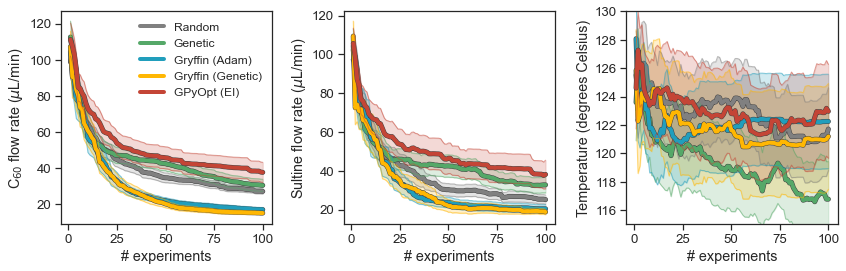

In [49]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

unc = True

plot_trace_mean_verbose(data_random, obj_num=0, ax=axes[0], color='gray', label='Random', unc=unc)
plot_trace_mean_verbose(data_random, obj_num=1, ax=axes[1], color='gray', unc=unc,)
plot_trace_mean_verbose(data_random, obj_num=2, ax=axes[2], color='gray', label='Random', unc=unc)

plot_trace_mean_verbose(data_deap, obj_num=0, ax=axes[0], color='g', label='Genetic', unc=unc)
plot_trace_mean_verbose(data_deap, obj_num=1, ax=axes[1], color='g', unc=unc,)
plot_trace_mean_verbose(data_deap, obj_num=2, ax=axes[2], color='g', label='Genetic', unc=unc)

plot_trace_mean_verbose(data_adam, obj_num=0, ax=axes[0], color='#219ebc', label='Gryffin (Adam)', unc=unc)
plot_trace_mean_verbose(data_adam, obj_num=1, ax=axes[1], color='#219ebc', unc=unc,)
plot_trace_mean_verbose(data_adam, obj_num=2, ax=axes[2], color='#219ebc', label='Gryffin (Adam)', unc=unc)

plot_trace_mean_verbose(data_gene, obj_num=0, ax=axes[0], color='#ffb703', label='Gryffin (Genetic)', unc=unc)
plot_trace_mean_verbose(data_gene, obj_num=1, ax=axes[1], color='#ffb703', unc=unc,)
plot_trace_mean_verbose(data_gene, obj_num=2, ax=axes[2], color='#ffb703', label='Gryffin (Genetic)', unc=unc)

plot_trace_mean_verbose(data_gpyopt, obj_num=0, ax=axes[0], color='#c44536', label='GPyOpt (EI)', unc=unc)
plot_trace_mean_verbose(data_gpyopt, obj_num=1, ax=axes[1], color='#c44536', unc=unc,)
plot_trace_mean_verbose(data_gpyopt, obj_num=2, ax=axes[2], color='#c44536', label='GPyOpt (EI)', unc=unc)

axes[2].set_ylim(115, 130)


axes[0].set_xlabel('# experiments')
axes[1].set_xlabel('# experiments')
axes[2].set_xlabel('# experiments')

axes[0].set_ylabel(r'C$_{60}$ flow rate ($\mu$L/min)')
axes[1].set_ylabel(r'Sultine flow rate ($\mu$L/min)')
axes[2].set_ylabel(r'Temperature (degrees Celsius)')

axes[0].legend(loc='upper right', frameon=False, ncol=1, fontsize=12, )

plt.tight_layout()
#plt.savefig('fullerenes-parameter-traces.png', dpi=300)

In [ ]:
# PLOT TRACES OF FLOW RATES WITH UNITS OF g/min ()

RANDOM C60 54.33667392366428	SULTINE 35.182624467892886
DEAP C60 61.043393831335635	SULTINE 45.82394024578505
ADAM C60 34.24013736179876	SULTINE 28.561751073838245
GENE C60 30.409878250616003	SULTINE 26.259195533805304
GPYOPT C60 75.42218142621489	SULTINE 53.355835772423355


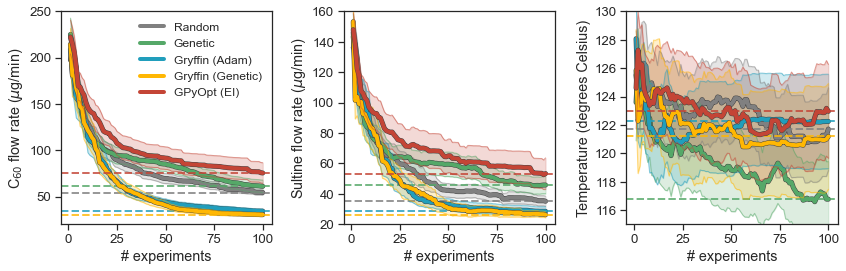

In [51]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

unc = True

random_c60 = plot_trace_mean_verbose(data_random, obj_num=0, ax=axes[0], color='gray', label='Random', unc=unc, convert_mu_g_min=True)
random_sultine = plot_trace_mean_verbose(data_random, obj_num=1, ax=axes[1], color='gray', unc=unc, convert_mu_g_min=True)
plot_trace_mean_verbose(data_random, obj_num=2, ax=axes[2], color='gray', label='Random', unc=unc, convert_mu_g_min=True)

deap_c60 =plot_trace_mean_verbose(data_deap, obj_num=0, ax=axes[0], color='g', label='Genetic', unc=unc, convert_mu_g_min=True)
deap_sultine = plot_trace_mean_verbose(data_deap, obj_num=1, ax=axes[1], color='g', unc=unc, convert_mu_g_min=True)
plot_trace_mean_verbose(data_deap, obj_num=2, ax=axes[2], color='g', label='Genetic', unc=unc, convert_mu_g_min=True)

adam_c60 = plot_trace_mean_verbose(data_adam, obj_num=0, ax=axes[0], color='#219ebc', label='Gryffin (Adam)', unc=unc, convert_mu_g_min=True)
adam_sultine = plot_trace_mean_verbose(data_adam, obj_num=1, ax=axes[1], color='#219ebc', unc=unc, convert_mu_g_min=True)
plot_trace_mean_verbose(data_adam, obj_num=2, ax=axes[2], color='#219ebc', label='Gryffin (Adam)', unc=unc, convert_mu_g_min=True)

gene_c60 = plot_trace_mean_verbose(data_gene, obj_num=0, ax=axes[0], color='#ffb703', label='Gryffin (Genetic)', unc=unc, convert_mu_g_min=True)
gene_sultine = plot_trace_mean_verbose(data_gene, obj_num=1, ax=axes[1], color='#ffb703', unc=unc, convert_mu_g_min=True)
plot_trace_mean_verbose(data_gene, obj_num=2, ax=axes[2], color='#ffb703', label='Gryffin (Genetic)', unc=unc, convert_mu_g_min=True)

gpyopt_c60 = plot_trace_mean_verbose(data_gpyopt, obj_num=0, ax=axes[0], color='#c44536', label='GPyOpt (EI)', unc=unc, convert_mu_g_min=True)
gpyopt_sultine = plot_trace_mean_verbose(data_gpyopt, obj_num=1, ax=axes[1], color='#c44536', unc=unc, convert_mu_g_min=True)
plot_trace_mean_verbose(data_gpyopt, obj_num=2, ax=axes[2], color='#c44536', label='GPyOpt (EI)', unc=unc, convert_mu_g_min=True)



print(f'RANDOM C60 {random_c60}\tSULTINE {random_sultine}')
print(f'DEAP C60 {deap_c60}\tSULTINE {deap_sultine}')
print(f'ADAM C60 {adam_c60}\tSULTINE {adam_sultine}')
print(f'GENE C60 {gene_c60}\tSULTINE {gene_sultine}')
print(f'GPYOPT C60 {gpyopt_c60}\tSULTINE {gpyopt_sultine}')

axes[0].set_ylim(20, 250)
axes[1].set_ylim(20, 160)

axes[2].set_ylim(115, 130)


axes[0].set_xlabel('# experiments')
axes[1].set_xlabel('# experiments')
axes[2].set_xlabel('# experiments')

axes[0].set_ylabel(r'C$_{60}$ flow rate ($\mu$g/min)')
axes[1].set_ylabel(r'Sultine flow rate ($\mu$g/min)')
axes[2].set_ylabel(r'Temperature (degrees Celsius)')

axes[0].legend(loc='upper right', frameon=False, ncol=1, fontsize=12, )

plt.tight_layout()
plt.savefig('fullerenes-parameter-traces-mu_g-min.png', dpi=300)

In [28]:
# get the final (best) recipe of the
best_random = v_traces_random[:, :5, -1]
d_rand = pd.DataFrame(best_random, columns=['c60_flow', 'sultine_flow', 'T', 'obj0', 'obj1'])
d_rand['strategy'] = 'random'


best_deap = v_traces_deap[:, :5, -1]
d_deap = pd.DataFrame(best_deap, columns=['c60_flow', 'sultine_flow', 'T', 'obj0', 'obj1'])
d_deap['strategy'] = 'deap'

best_adam = v_traces_adam[:, :5, -1]
d_adam = pd.DataFrame(best_adam, columns=['c60_flow', 'sultine_flow', 'T', 'obj0', 'obj1'])
d_adam['strategy'] = 'adam'

best_gene = v_traces_gene[:, :5, -1]
d_gene = pd.DataFrame(best_gene, columns=['c60_flow', 'sultine_flow', 'T', 'obj0', 'obj1'])
d_gene['strategy'] = 'gene'

best_gpyopt = v_traces_gpyopt[:, :5, -1]
d_gpyopt = pd.DataFrame(best_gpyopt, columns=['c60_flow', 'sultine_flow', 'T', 'obj0', 'obj1'])
d_gpyopt['strategy'] = 'gpyopt'

d = pd.concat((d_rand, d_deap, d_adam, d_gene, d_gpyopt))

# convert the flow rates to \mu g / min for equal comparison
d['c60_flow'] = d['c60_flow']*2.0
d['sultine_flow'] = d['sultine_flow']*1.4

print(d.shape)
d.head()

(500, 6)


,c60_flow,sultine_flow,T,obj0,obj1,strategy
0,49.850562,40.934810,119.556292,0.911539,0.004286,random
1,41.605276,27.858895,112.461783,0.927261,0.003565,random
2,66.253745,31.837028,123.559078,0.914412,0.005653,random
3,46.871191,23.599970,149.478324,0.944081,0.004001,random
4,29.131448,33.199052,100.341882,0.903508,0.002522,random


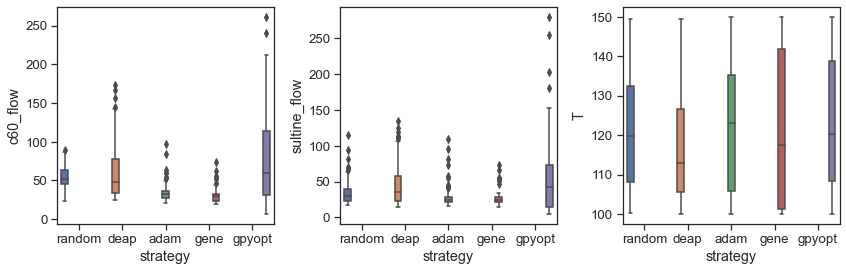

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

_ = sns.boxplot(data=d, x='strategy', y='c60_flow', hue='strategy', ax=axes[0])

_ = sns.boxplot(data=d, x='strategy', y='sultine_flow', hue='strategy', ax=axes[1])
_ = sns.boxplot(data=d, x='strategy', y='T', hue='strategy', ax=axes[2])

for ax in axes:
    ax.legend([],[], frameon=False)
    
plt.tight_layout()

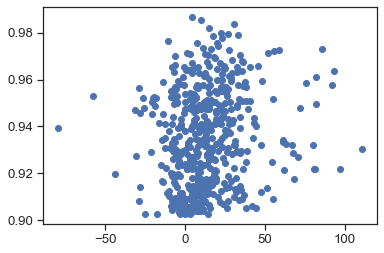

In [44]:
plt.scatter(d.c60_flow-d.sultine_flow, d.obj0.values)

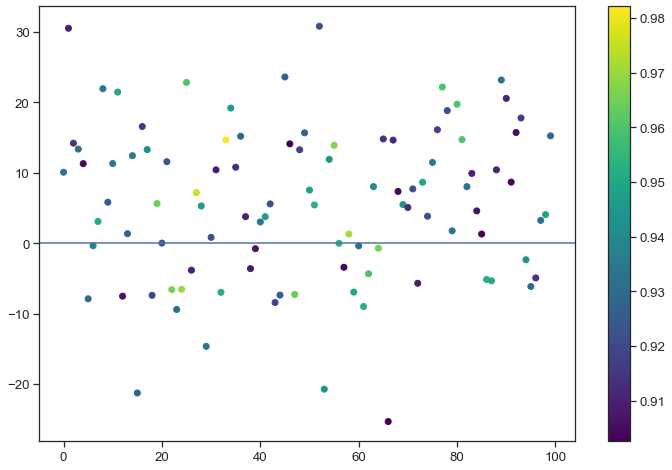

In [42]:
# plt.scatter(np.arange(d_adam.shape[0]), d_adam.c60_flow-d_adam.sultine_flow)
# plt.axhline(0.)

fig, ax = plt.subplots(1,1,figsize=(12, 8))

sub_d = d[d.strategy=='adam']

im = plt.scatter(
    np.arange(sub_d.shape[0]), sub_d.c60_flow-sub_d.sultine_flow, c=sub_d.obj0.values, cmap='viridis',
)
plt.colorbar(im)

plt.axhline(0.)


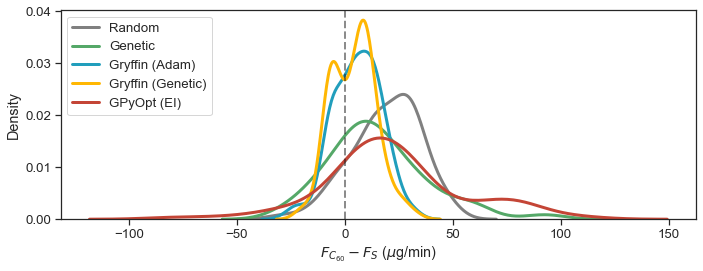

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

for strategy, c, l in zip(['random', 'deap', 'adam', 'gene', 'gpyopt'], ['gray', 'g', '#219ebc', '#ffb703', '#c44536'], 
                         ['Random', 'Genetic', 'Gryffin (Adam)', 'Gryffin (Genetic)', 'GPyOpt (EI)']):
    sub_d = d[d.strategy==strategy]
    sns.distplot(sub_d.c60_flow-sub_d.sultine_flow, color=c, hist=False, ax=ax, kde_kws={'lw':3, 'alpha':0.8},
                label=l)

ax.axvline(0., ls='--', lw=2, c='k', alpha=0.5)

ax.set_xlabel(r'$F_{C_{60}} - F_{S}$ ($\mu$g/min)')

ax.legend(loc='upper left')

plt.tight_layout()
plt.savefig('flow_rate_diff_kde.png', dpi=400)


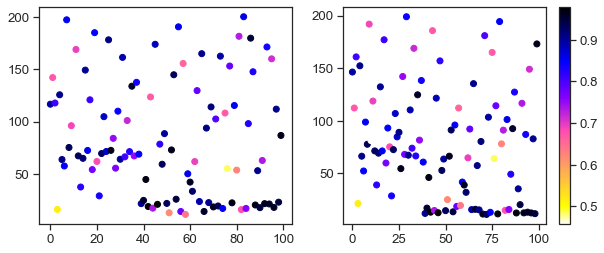

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

colors = data_gene[0].obj0.values
im = axes[0].scatter(np.arange(len(data_gene[0].c60_flow)), data_gene[0].c60_flow, c=colors, cmap='gnuplot2_r')  

im = axes[1].scatter(np.arange(len(data_gene[0].sultine_flow)), data_gene[0].sultine_flow, c=colors, cmap='gnuplot2_r') 
fig.colorbar(im)

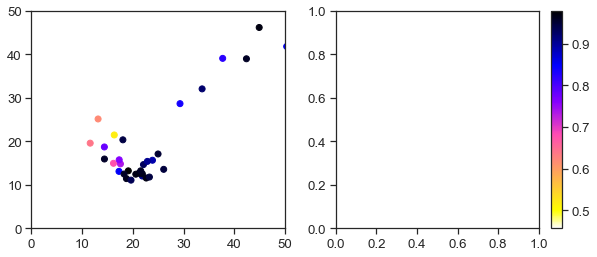

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
colors = data_gene[0].obj0.values
im = axes[0].scatter(data_gene[0].c60_flow, data_gene[0].sultine_flow, c=colors, cmap='gnuplot2_r')  
axes[0].set_xlim(0, 50)
axes[0].set_ylim(0, 50)
fig.colorbar(im)

In [43]:
# load thetraining data 
df_train = pickle.load(open('emulator_train_data.pkl', 'rb'))
df_train['obj0'] = df_train['BA']/df_train['MA']
df_train['obj1'] = df_train['TA']
print(df_train.shape)
print(df_train.columns)

df_train.head()


(600, 9)
Index(['c60_flow', 'sultine_flow', 'T', 'NA', 'MA', 'BA', 'TA', 'obj0',
       'obj1'],
      dtype='object')


,c60_flow,sultine_flow,T,NA,MA,BA,TA,obj0,obj1
0,73.777013,139.862987,141.15,0.000000,0.123069,0.493082,0.383849,4.006557,0.383849
1,47.975387,29.864613,134.75,0.032046,0.700855,0.232875,0.034224,0.332273,0.034224
2,146.751920,80.888080,115.85,0.144684,0.763265,0.085645,0.006406,0.112209,0.006406
3,21.782227,17.137773,147.50,0.011557,0.587944,0.327834,0.072665,0.557593,0.072665
4,63.006720,44.513280,101.70,0.160928,0.762194,0.072458,0.004420,0.095065,0.004420


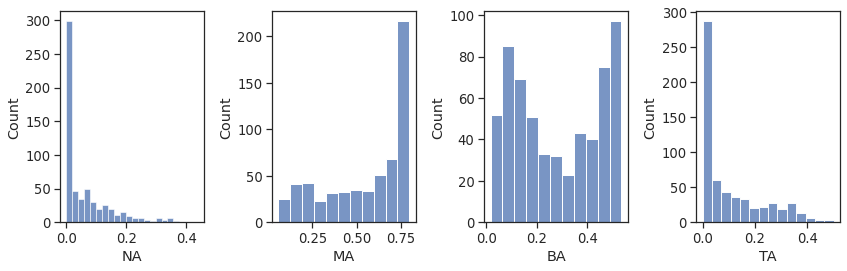

In [37]:
fig, axes = plt.subplots(1, 4, figsize=(12, 4))

sns.histplot(df_train['NA'], ax=axes[0])
sns.histplot(df_train['MA'], ax=axes[1])
sns.histplot(df_train['BA'], ax=axes[2])
sns.histplot(df_train['TA'], ax=axes[3])

plt.tight_layout()

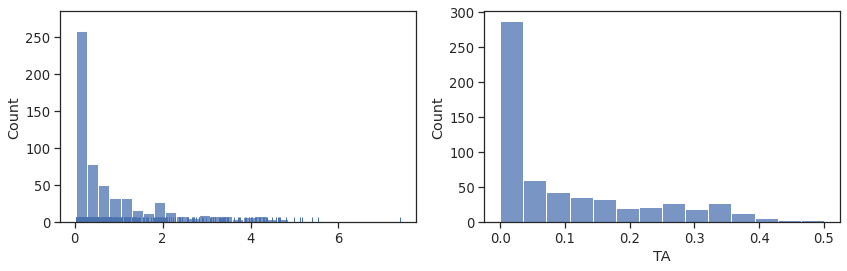

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(df_train['BA']/df_train['MA'], ax=axes[0])
sns.rugplot(df_train['BA']/df_train['MA'], ax=axes[0])

#sns.boxplot(df_train, ax=axes[1])
sns.histplot(df_train['TA'], ax=axes[1])

plt.tight_layout()

In [13]:
# get verbose traces
traces_adam = get_traces_verbose(data_adam)

print(traces_adam.shape)
ITER_NUM = 0

#print(traces_adam[-1].shape)
#final_adam = traces_adam[-1]
final_adam_c60 = [t[0][ITER_NUM] for t in traces_adam]
final_adam_sultine = [t[1][ITER_NUM] for t in traces_adam]
final_adam_T = [t[2][ITER_NUM] for t in traces_adam]
final_adam_obj1 = [t[3][ITER_NUM] for t in traces_adam]
final_adam_obj2 = [t[4][ITER_NUM] for t in traces_adam]

traces_gene = get_traces_verbose(data_gene)

final_gene_c60 = [t[0][ITER_NUM] for t in traces_gene]
final_gene_sultine = [t[1][ITER_NUM] for t in traces_gene]
final_gene_T = [t[2][ITER_NUM] for t in traces_gene]
final_gene_obj1 = [t[3][ITER_NUM] for t in traces_gene]
final_gene_obj2 = [t[4][ITER_NUM] for t in traces_gene]



(60, 7, 100)


In [14]:
print(np.amax(final_gene_obj1))
print(np.amax(final_gene_obj2))

print(np.amax(final_adam_obj1))
print(np.amax(final_adam_obj2))

6.090590000152588
0.44846242666244507
10.801870346069336
0.4740324020385742


In [15]:
## fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

p = ax.scatter(
    final_adam_c60,
    final_adam_sultine,
    final_adam_T,
    c=final_adam_obj1,
    cmap='turbo',
)
fig.colorbar(p, ax=ax)
ax.set_xlabel('c60')
ax.set_ylabel('sultine')
ax.set_zlabel('T')

Text(0.5, 0, 'T')

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(15, 4))
sns.histplot(final_adam_obj1, ax=axes[0])
axes[0].set_title('objective 1')
sns.histplot(final_adam_c60, ax=axes[1])
axes[1].set_title('c60 flow')
sns.histplot(final_adam_sultine, ax=axes[2])
axes[2].set_title('sultine flow')
sns.histplot(final_adam_T, ax=axes[3])
axes[3].set_title('T')

plt.tight_layout()

print(final_adam_sultine)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

p = ax.scatter(
    final_adam_c60,
    final_adam_sultine,
    final_adam_T,
    c=final_adam_obj2,
    cmap='turbo',
)
fig.colorbar(p, ax=ax)
ax.set_xlabel('c60')
ax.set_ylabel('sultine')
ax.set_zlabel('T')

ax.set_title('adam obj2')
plt.savefig('adam_obj2.png', dpi=300)

In [ ]:
fig, ax = plt.subplots(1, 1)
sns.histplot(final_adam_obj2)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

p = ax.scatter(
    final_gene_c60,
    final_gene_sultine,
    final_gene_T,
    c=final_gene_obj1,
    cmap='turbo',
)
fig.colorbar(p, ax=ax)
ax.set_xlabel('c60')
ax.set_ylabel('sultine')
ax.set_zlabel('T')

In [ ]:
fig, ax = plt.subplots(1, 1)
sns.histplot(final_gene_obj1)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

p = ax.scatter(
    final_gene_c60,
    final_gene_sultine,
    final_gene_T,
    c=final_gene_obj2,
    cmap='turbo',
)
fig.colorbar(p, ax=ax)
ax.set_xlabel('c60')
ax.set_ylabel('sultine')
ax.set_zlabel('T')

#print(final_gene_c60.shape)
ax.set_title('genetic obj2')
plt.savefig('genetic_obj2.png', dpi=300)

In [ ]:
fig, ax = plt.subplots(1, 1)
sns.histplot(final_gene_obj2)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

sub_df = df_train[(df_train['TA'])<1]

p = ax.scatter(
    df_train['c60_flow'],
    df_train['sultine_flow'],
    df_train['T'],
    c=df_train['TA'],
    cmap='turbo',
)
fig.colorbar(p, ax=ax)
ax.set_xlabel('c60')
ax.set_ylabel('sultine')
ax.set_zlabel('T')

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

sub_df = df_train[(df_train['BA'] / df_train['MA'])<1]

p = ax.scatter(
    sub_df['c60_flow'],
    sub_df['sultine_flow'],
    sub_df['T'],
    c= sub_df['BA'] / sub_df['MA'] ,
    cmap='turbo',
)
fig.colorbar(p, ax=ax)
ax.set_xlabel('c60')
ax.set_ylabel('sultine')
ax.set_zlabel('T')

In [ ]:

df_train['obj0'] = df_train['BA']/df_train['MA']
df_train['obj1'] = df_train['TA']
scalarized = chimera.scalarize(df_train.loc[:, ['obj0', 'obj1']])


In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

p = ax.scatter(
    df_train['c60_flow'],
    df_train['sultine_flow'],
    df_train['T'],
    c=scalarized,
    cmap='turbo',
)
fig.colorbar(p, ax=ax)
ax.set_xlabel('c60')
ax.set_ylabel('sultine')
ax.set_zlabel('T')

## Load probailistic emulator and visualize predictions

In [23]:
import sys
import torch
from emulator import BayesianNetwork

In [24]:
device = 'cpu'
model = BayesianNetwork(3, 4, 64).to(device)
checkpoint = 'torch_prod_models/fullerenes.pth'
model.load_state_dict(torch.load(checkpoint))
# load feature scaler
feature_scaler = pickle.load(open('torch_prod_models/feature_scaler.pkl', 'rb'))

In [25]:
# helper functions  for generating params and measuremetns

def __BACKUP_run_experiment(param):
    
    if known_constraints(param):
        c60 = param['c60_flow']
        sul = param['sultine_flow'] 
        T = param['T'] 

        x = np.array([[c60, sul, T]])
        na, ma, ba, ta = model.predict(x)[0]
    else: # hardcode for plotting purposes --> set to max
        na = 0.0
        ma = 0.8109182
        ba = 1.0
        ta = 0.171726

    return na, ma, ba, ta

def run_experiment(param):
    if known_constraints(param):
        c60 = param['c60_flow']
        sul = param['sultine_flow']
        T = param['T']

        x = np.array([[c60, sul, T]])
        _x  = feature_scaler.transform(x)
        pred, _ = model.predict(torch.tensor(_x).float())
        na, ma, ba, ta = pred.cpu().detach().numpy()[0]

        return na, ma, ba, ta
    else:
        # hardcode for plotting purposes --> set to max
        na = 0.0
        ma = 0.8109182
        ba = 1.0
        ta = 0.171726
    
    return na, ma, ba, ta
        


def eval_merit(param):
    na, ma, ba, ta = run_experiment(param)
    param['obj0'] = ba / ma  # obj0 = max MA and BA
    param['obj1'] = ta   # obj1 = min TA
    #param['obj2'] = ma   # obj2 = max BA

    # append also individual fractions
    param['NA'] = na
    param['MA'] = ma
    param['BA'] = ba
    param['TA'] = ta
    return param

def get_samples(n=100, T = 106.45796):
    samples = []
    while len(samples) < n:
        c60 = np.random.uniform(low=0., high=200.)
        sul = np.random.uniform(low=0., high=200.)
        #T = np.random.uniform(low=100., high=150.)
        param = {'c60_flow': c60, 'sultine_flow': sul, 'T':T}
        #if known_constraints(param) is True:
        samples.append(param)
    return samples

def get_grid_samples(res=50, T=106.45796):
    c60 = np.linspace(0, 200, res)
    sultine = np.linspace(0, 200, res)
    X, Y = np.meshgrid(c60, sultine)
    inputs = np.dstack([X, Y]).reshape(-1, 2)
    
    samples = []
    for input_ in inputs:
        samples.append({'c60_flow': input_[0], 'sultine_flow': input_[1], 'T':T})
    
    return samples, inputs, X, Y
    
def known_constraints(param):
    flow_sum = param['c60_flow'] + param['sultine_flow']
    b0 = 30. < flow_sum < 310.
    b1 = np.logical_and(param['c60_flow'] > 0.5 * param['sultine_flow'],
                        param['c60_flow'] < 2. * param['sultine_flow'])
    
    if np.logical_and(b0, b1) == True:
        return True
    else:
        return False

In [26]:
RES = 60

samples, inputs, X, Y = get_grid_samples(res=RES, T=106.45796)

len(samples), inputs.shape

(3600, (3600, 2))

In [49]:
observations = []
for param in samples:
    observation_samps = [ eval_merit(param) for _ in range(20) ]
    
    observations.append(observation_samps)


In [51]:
z0_mean = np.array([np.mean([o_elem['obj0'] for o_elem in o]) for o in observations])
z1_mean = np.array([np.mean([o_elem['obj1'] for o_elem in o]) for o in observations])

z0_std = np.array([np.std([o_elem['obj0'] for o_elem in o]) for o in observations])
z1_std = np.array([np.std([o_elem['obj1'] for o_elem in o]) for o in observations])

In [52]:
Z0_mean = z0_mean.reshape((RES, RES))
Z1_mean = z1_mean.reshape((RES, RES))

Z0_std = z0_std.reshape((RES, RES))
Z1_std = z1_std.reshape((RES, RES))

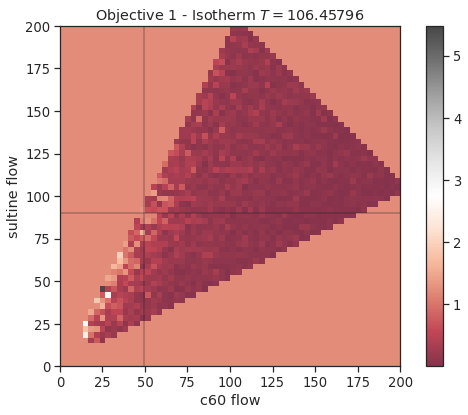

In [53]:
# OBJ 0 MEAN
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

#contours = ax.contour(X, Y, Z0, 3, colors='black')
#ax.clabel(contours, inline=True, fontsize=8)
im = ax.imshow(Z0_mean, extent=[0, 200, 0, 200], origin='lower', cmap='RdGy', alpha=0.8)
plt.colorbar(im)
ax.set_xlabel('c60 flow')
ax.set_ylabel('sultine flow')

ax.axhline(90, c='k', alpha=0.3)
ax.axvline(49.5, c='k', alpha=0.3)
ax.set_title(r'Objective 1 - Isotherm $T=106.45796$')

plt.tight_layout()
plt.savefig(r'Objective 1 - Isotherm $T=106.45796$.png', dpi=300 )

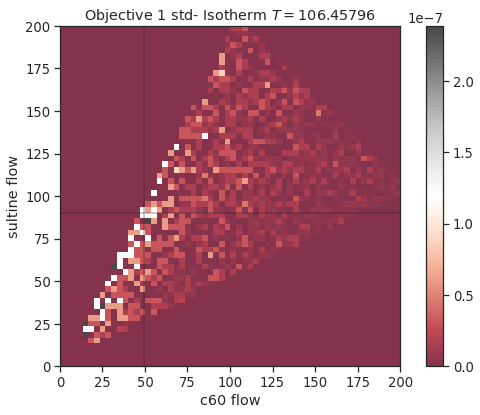

In [54]:
# OBJ 0 STD
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

#contours = ax.contour(X, Y, Z0, 3, colors='black')
#ax.clabel(contours, inline=True, fontsize=8)
im = ax.imshow(Z0_std, extent=[0, 200, 0, 200], origin='lower', cmap='RdGy', alpha=0.8)
plt.colorbar(im)
ax.set_xlabel('c60 flow')
ax.set_ylabel('sultine flow')

ax.axhline(90, c='k', alpha=0.3)
ax.axvline(49.5, c='k', alpha=0.3)
ax.set_title(r'Objective 1 std- Isotherm $T=106.45796$')

plt.tight_layout()
plt.savefig(r'Objective 1 std- Isotherm $T=106.45796$.png', dpi=300 )

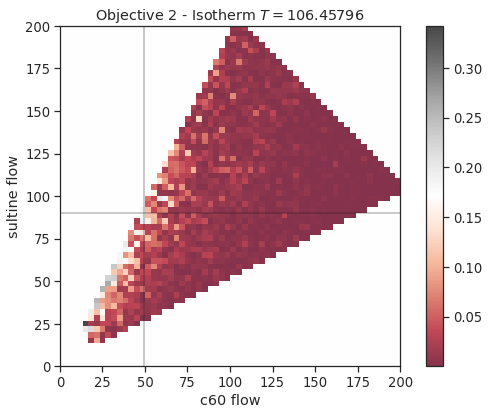

In [55]:
# OBJ 1 MEAN
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

#contours = ax.contour(X, Y, Z0, 3, colors='black')
#ax.clabel(contours, inline=True, fontsize=8)
im = ax.imshow(Z1_mean, extent=[0, 200, 0, 200], origin='lower', cmap='RdGy', alpha=0.8)
plt.colorbar(im)
ax.set_xlabel('c60 flow')
ax.set_ylabel('sultine flow')

ax.axhline(90, c='k', alpha=0.3)
ax.axvline(49.5, c='k', alpha=0.3)
ax.set_title(r'Objective 2 - Isotherm $T=106.45796$')

plt.tight_layout()
plt.savefig(r'Objective 2 - Isotherm $T=106.45796$.png', dpi=300 )

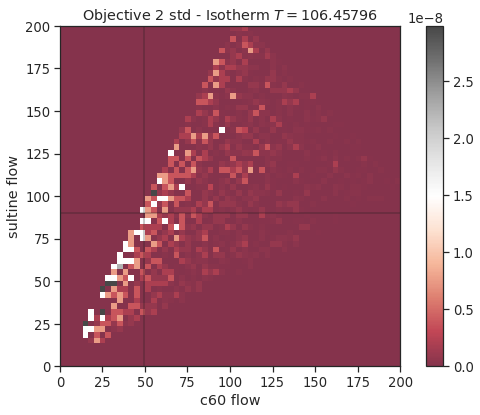

In [56]:
# OBJ 1 STD
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

#contours = ax.contour(X, Y, Z0, 3, colors='black')
#ax.clabel(contours, inline=True, fontsize=8)
im = ax.imshow(Z1_std, extent=[0, 200, 0, 200], origin='lower', cmap='RdGy', alpha=0.8)
plt.colorbar(im)
ax.set_xlabel('c60 flow')
ax.set_ylabel('sultine flow')

ax.axhline(90, c='k', alpha=0.3)
ax.axvline(49.5, c='k', alpha=0.3)
ax.set_title(r'Objective 2 std - Isotherm $T=106.45796$')

plt.tight_layout()
plt.savefig(r'Objective 2 std - Isotherm $T=106.45796$.png', dpi=300 )

In [ ]:
# plot all isotherms 104 to 130 deg C 

Ts = np.linspace(104, 130, 10)

all_results = []

for T in Ts:

    RES = 60

    samples, inputs, X, Y = get_grid_samples(res=RES, T=T)

    observations = []
    for param in samples:
        observation = eval_merit(param)
        observations.append(observation)
        
    z0 = np.array([o['obj0'] for o in observations])
    z1 = np.array([o['obj1'] for o in observations])

    Z0 = z0.reshape((RES, RES))
    Z1 = z1.reshape((RES, RES))


    fig, ax = plt.subplots(1, 1)

    #contours = ax.contour(X, Y, Z0, 3, colors='black')
    #ax.clabel(contours, inline=True, fontsize=8)
    im = ax.imshow(Z0, extent=[0, 200, 0, 200], origin='lower', cmap='RdGy', alpha=0.8)
    plt.colorbar(im)
    ax.set_xlabel('c60 flow')
    ax.set_ylabel('sultine flow')

    ax.axhline(90, c='k', alpha=0.3)
    ax.axvline(49.5, c='k', alpha=0.3)
    ax.set_title(f'Objective 1 - Isotherm {T}')

    plt.tight_layout()
    plt.savefig(f'isotherms/Objective 1 - Isotherm {T}.png', dpi=300)

    fig, ax = plt.subplots(1, 1)

    #contours = ax.contour(X, Y, Z0, 3, colors='black')
    #ax.clabel(contours, inline=True, fontsize=8)
    im = ax.imshow(Z1, extent=[0, 200, 0, 200], origin='lower', cmap='RdGy', alpha=0.8)
    plt.colorbar(im)
    ax.set_xlabel('c60 flow')
    ax.set_ylabel('sultine flow')

    ax.axhline(90, c='k', alpha=0.3)
    ax.axvline(49.5, c='k', alpha=0.3)
    ax.set_title(f'Objective 2 - Isotherm {T}')

    plt.tight_layout()
    plt.savefig(f'isotherms/Objective 2 - Isotherm {T}.png', dpi=300)